In [1]:
# jupyter notebooks name can start with author initials
# to maintain track of work

In [2]:
import pandas as pd

In [4]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

In [5]:
df.shape

(260601, 39)

In [7]:
from collections import Counter

In [8]:
train_target.columns

Index(['building_id', 'damage_grade'], dtype='object')

In [9]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

In [10]:
import seaborn as sns

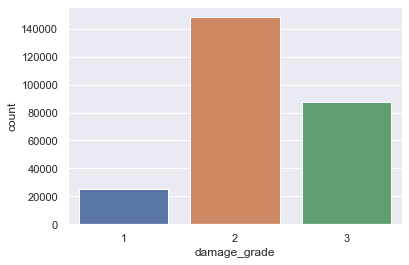

In [11]:
sns.set(style="darkgrid")

ax = sns.countplot(x="damage_grade", data=train_target)

In [15]:
# Metric to be used
# F1 score with argument micro has to be used

In [16]:
from sklearn.metrics import f1_score

f1_score(y_true= , y_pred = average='micro')

In [17]:
## Base line model

In [18]:
# lets see our f1 score (micro) when we always predict the 2nd class

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Current f1_score on the leaderboard is 0.7544

We are very near this 